In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # limit gpu memory
    
from psychrnn.tasks.task import Task
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.models.lstm import LSTM
import numpy as np
import scipy.io
import pandas as pd
import pickle
import numpy as np
from itertools import product
from typing import *
import os
import json
from uuid import uuid4, UUID
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from subprocess import Popen, DEVNULL
from stat import S_IEXEC
from time import sleep

2022-11-16 01:07:25.722606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 01:07:25.901507: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 01:07:26.423590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2022-11-16 01:07:26.423717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: 

# Load teena's data that's organized-ish

In [2]:
teena_data = pd.read_pickle("./teena_df.pickle")

In [3]:
teena_data

,traj,file,sf
0,"[[222.1209111213684, 168.07275390625], [221.94...",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,True
1,"[[169.10160207748413, 175.90780782699585], [16...",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,False
2,"[[230.9175843000412, 184.91174030303955], [231...",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,False
3,"[[211.2449939250946, 173.9231698513031], [211....",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,True
4,"[[294.99583292007446, 73.52325487136841], [294...",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,True
...,...,...,...
924,"[[105.88987445831299, 211.26179087162018], [10...",/data2/kushal/inter_region/JoyM2/072619_PT/Beh...,True
925,"[[99.2321879863739, 205.92135858535767], [99.0...",/data2/kushal/inter_region/JoyM2/072619_PT/Beh...,True
926,"[[101.94186615943909, 202.87839889526367], [10...",/data2/kushal/inter_region/JoyM2/072619_PT/Beh...,True
927,"[[99.41120111942291, 205.7405904531479], [99.7...",/data2/kushal/inter_region/JoyM2/072619_PT/Beh...,True


# Use only success data

In [4]:
# use only success data
teena_data = teena_data[teena_data["sf"] == True]
teena_data

,traj,file,sf
0,"[[222.1209111213684, 168.07275390625], [221.94...",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,True
3,"[[211.2449939250946, 173.9231698513031], [211....",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,True
4,"[[294.99583292007446, 73.52325487136841], [294...",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,True
5,"[[285.5730181336403, 78.19226586818695], [285....",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,True
6,"[[279.1388177871704, 78.51209497451782], [279....",/data2/kushal/inter_region/JoyJ2/121819_IT/Beh...,True
...,...,...,...
924,"[[105.88987445831299, 211.26179087162018], [10...",/data2/kushal/inter_region/JoyM2/072619_PT/Beh...,True
925,"[[99.2321879863739, 205.92135858535767], [99.0...",/data2/kushal/inter_region/JoyM2/072619_PT/Beh...,True
926,"[[101.94186615943909, 202.87839889526367], [10...",/data2/kushal/inter_region/JoyM2/072619_PT/Beh...,True
927,"[[99.41120111942291, 205.7405904531479], [99.7...",/data2/kushal/inter_region/JoyM2/072619_PT/Beh...,True


# `dstack`, shape should be [n_frames_vid, xy, n_trials]

In [5]:
teena_data_array = np.dstack(teena_data["traj"])
teena_data_array.shape

(4997, 2, 702)

# Use only first 2500 frames, behavior usually occurs within this timespan

In [6]:
traj_data = teena_data_array[:2500, :, :100]

In [7]:
traj_data.shape

(2500, 2, 100)

# Define behavioral task, basically just samples `traj_data`

In [8]:
class Reach2Grab(Task):
    def __init__(self, dt, tau, T, N_batch):
        super(Reach2Grab, self).__init__(1, 2, dt, tau, T, N_batch)

    def generate_trial_params(self, batch, trial):
        """"Define parameters for each trial.

        Using a combination of randomness, presets, and task attributes, define the necessary trial parameters.

        Args:
            batch (int): The batch number that this trial is part of.
            trial (int): The trial number of the trial within the batch.

        Returns:
            dict: Dictionary of trial parameters.

        """

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params["trial_ix"] = np.random.randint(0, traj_data.shape[2])

        return params

    def trial_function(self, time, params):
        """ Compute the trial properties at the given time.

        Based on the params compute the trial stimulus (x_t), correct output (y_t), and mask (mask_t) at the given time.

        Args:
            time (int): The time within the trial (0 <= time < T).
            params (dict): The trial params produced generate_trial_params()

        Returns:
            tuple:

            x_t (ndarray(dtype=float, shape=(N_in,))): Trial input at time given params.
            y_t (ndarray(dtype=float, shape=(N_out,))): Correct trial output at time given params.
            mask_t (ndarray(dtype=bool, shape=(N_out,))): True if the network should train to match the y_t, False if the network should ignore y_t when training.

        """
        x_t = 1 # just a "go" cue
        y_t = traj_data[time, :, params["trial_ix"]]
        
        mask_t = np.ones(shape=y_t.shape, dtype=bool)
        
        # trajectory that matches direction 
        
        # y_t returns a trajectory

        return x_t, y_t, mask_t

# functions to save and load models to a dir because PsychRNN doesn't implement this properly ¯\\\_(ツ)_/¯

In [9]:
def save_model(m: Union[Basic, LSTM], u: Union[str, UUID]):
    d = Path(f"/home/kushalk/repos/rnn-go-brr/rnngobrr/models/{u}")
    weights_path = d.joinpath("weights")
    params_path = d.joinpath("params.json")
    os.mkdir(d)
    
    m.save(weights_path)
    json.dump(m.params, open(params_path, "w"))


def load_model(m: str, u: Union[str, UUID]) -> Union[Basic, LSTM]:
    d = Path(f"/home/kushalk/repos/rnn-go-brr/rnngobrr/models/{u}")
    # need to specify extension, these guys are so inconsistent (╯°□°)╯︵ ┻━┻
    weights_path = d.joinpath("weights.npz")
    params_path = d.joinpath("params.json")
    
    params = json.load(open(params_path, "r"))
    params["name"] = str(u)
    params["load_weights_path"] = weights_path
    
    if m == "Basic":
        return Basic(params)
    elif m == "LSTM":
        return LSTM(params)

# `gs_params` defines search range for each param

In [10]:
gs_params = {
    "dt": list(range(1, 13, 2)),
    "tau": list(range(10, 201, 50)),
    "T": [traj_data.shape[0]], # num frames to use
    "learning_rate": 1 / 10 ** np.arange(4, 10, 2),
    "training_iters": list(range(100, 501, 100)),
    "N_rec": list(range(100, 501, 200)), # number of neurons
}

# this is the same order that must be used when using the iterator!!
# dict keys don't return stuff in order, so gs_params.keys() shouldn't be used for this!!
gs_param_names = [
    "dt",
    "tau",
    "T",
    "learning_rate",
    "training_iters",
    "N_rec"
]

gs_params

{'dt': [1, 3, 5, 7, 9, 11],
 'tau': [10, 60, 110, 160],
 'T': [2500],
 'learning_rate': array([1.e-04, 1.e-06, 1.e-08]),
 'training_iters': [100, 200, 300, 400, 500],
 'N_rec': [100, 300, 500]}

# Create iterator using all possible combinations of search parameters, check number of variants

In [11]:
iterator = product(*[gs_params[k] for k in gs_param_names])
iterator = list(iterator)
len(iterator)

1080

# Write dataframe to use for gridsearch

In [12]:
columns = gs_param_names + ["uuid", "arch", "task_params"]

df = pd.DataFrame(columns=columns)


for dt, tau, T, learning_rate, training_iters, N_rec in tqdm(iterator, total=len(iterator)):
    u = uuid4() # to keep track of this model
    
    # create df row
    s = pd.Series(
        {
            "uuid": str(u),
            "arch": "Basic",
            "dt": dt,
            "tau": tau,
            "T": T,
            "learning_rate": learning_rate,
            "training_iters": training_iters,
            "N_rec": N_rec,
            "task_params": Reach2Grab(dt=dt, tau=tau, T=T, N_batch=128).get_task_params()
        }
    )
    
    # append to dataframe
    df.loc[df.index.size] = s

df.to_pickle("./models_dataframe.pickle")

100%|████████████████████████████████████████████████████████████████████| 1080/1080 [00:01<00:00, 913.92it/s]


In [13]:
!mkdir ./runfiles

mkdir: cannot create directory ‘./runfiles’: File exists


# Use `subprocess` to do the gridsearch since tensorflow sessions can't be pickled so process Pool doesn't work

In [ ]:
processes = list()

for i, r in tqdm(df.iterrows(), total=df.index.size):
    runfile =\
        f"#!/bin/bash\n"\
        f"source /home/kushalk/.bashrc\n"\
        f"source /home/kushalk/python-venvs/stor566/bin/activate\n"\
        f"python /home/kushalk/repos/rnn-go-brr/rnngobrr/run_grid.py --uuid {r.uuid}"
    
    runfile_path = f"./runfiles/{r.uuid}"
    
    with open(runfile_path, "w") as f:
        f.write(runfile)
        
    st = os.stat(runfile_path)
    os.chmod(runfile_path, st.st_mode | S_IEXEC)
    
    proc = Popen(runfile_path, cwd="./", stderr=DEVNULL)
    processes.append(proc)
    
    while [p.poll() is None for p in processes].count(True) > 20: # set max number of simultaneous subprocs
        sleep(5)

  1%|▉                                                                     | 14/1080 [00:13<00:07, 138.09it/s]

Optimization finished!
Optimization finished!


  2%|█▎                                                                   | 21/1080 [03:20<3:30:27, 11.92s/it]

Optimization finished!


  2%|█▍                                                                   | 22/1080 [03:30<3:27:38, 11.78s/it]

Optimization finished!


  2%|█▍                                                                   | 23/1080 [03:40<3:24:22, 11.60s/it]

Optimization finished!
Optimization finished!


  2%|█▌                                                                   | 24/1080 [04:03<3:09:38, 10.77s/it]

Optimization finished!


  2%|█▋                                                                  | 27/1080 [09:05<12:59:05, 44.39s/it]

Optimization finished!


  4%|██▋                                                                  | 42/1080 [10:31<2:38:29,  9.16s/it]

Optimization finished!
Optimization finished!


  4%|██▊                                                                  | 44/1080 [10:46<2:26:21,  8.48s/it]

Optimization finished!


  5%|███▏                                                                 | 49/1080 [11:06<1:38:31,  5.73s/it]

Optimization finished!
Optimization finished!


  5%|███▎                                                                 | 52/1080 [12:06<3:10:18, 11.11s/it]

Optimization finished!


  6%|███▉                                                                 | 62/1080 [13:16<1:41:04,  5.96s/it]

Optimization finished!
Optimization finished!


  6%|████                                                                 | 63/1080 [13:31<2:18:33,  8.17s/it]

Optimization finished!
Optimization finished!


  6%|████▏                                                                | 66/1080 [13:46<1:45:45,  6.26s/it]

Optimization finished!


  6%|████▎                                                                | 68/1080 [14:07<2:13:44,  7.93s/it]

Optimization finished!
Optimization finished!


  6%|████▍                                                                | 70/1080 [16:32<8:39:07, 30.84s/it]

Optimization finished!


  7%|████▌                                                                | 71/1080 [16:52<7:50:02, 27.95s/it]

Optimization finished!


  7%|████▋                                                               | 74/1080 [20:27<14:07:48, 50.57s/it]

Optimization finished!
Optimization finished!


  7%|████▋                                                               | 75/1080 [20:52<12:02:23, 43.13s/it]

Optimization finished!


  7%|████▉                                                                | 77/1080 [21:07<7:30:32, 26.95s/it]

Optimization finished!


  7%|█████                                                                | 79/1080 [22:02<7:30:46, 27.02s/it]

Optimization finished!


  8%|█████▎                                                               | 83/1080 [22:47<4:08:19, 14.94s/it]

Optimization finished!
Optimization finished!


  8%|█████▌                                                               | 88/1080 [23:17<2:01:06,  7.32s/it]

Optimization finished!
Optimization finished!


  8%|█████▋                                                               | 89/1080 [23:32<2:28:57,  9.02s/it]

Optimization finished!
Optimization finished!


  9%|█████▉                                                               | 92/1080 [23:48<1:54:25,  6.95s/it]

Optimization finished!


  9%|█████▉                                                               | 93/1080 [24:53<5:39:43, 20.65s/it]

Optimization finished!


  9%|██████                                                               | 94/1080 [25:48<8:01:52, 29.32s/it]

Optimization finished!


  9%|██████▏                                                              | 96/1080 [26:08<5:33:21, 20.33s/it]

Optimization finished!


  9%|██████▏                                                              | 97/1080 [26:18<4:45:32, 17.43s/it]

Optimization finished!


  9%|██████▎                                                              | 98/1080 [26:33<4:34:02, 16.74s/it]

Optimization finished!


  9%|██████▎                                                              | 99/1080 [26:43<4:01:52, 14.79s/it]

Optimization finished!


  9%|██████▎                                                            | 102/1080 [30:38<15:31:51, 57.17s/it]

Optimization finished!


 10%|██████▋                                                             | 106/1080 [31:08<6:15:54, 23.16s/it]

Optimization finished!


 10%|██████▊                                                             | 109/1080 [31:23<3:30:52, 13.03s/it]

# Old stuff below

In [21]:
columns = gs_param_names + ["uuid", "arch"]

df = pd.DataFrame(columns=columns)

for dt, tau, T, learning_rate, training_iters, N_rec in tqdm(iterator, total=n_combos):
    u = uuid4() # to keep track of this model
    
    task = Reach2Grab(dt=dt, tau=tau, T=T, N_batch=128)
    
    network_params = task.get_task_params()
    network_params['name'] = str(u)
    network_params['N_rec'] = N_rec
    
    model_iter = Basic(network_params)

    train_params = {
        "training_iters": training_iters,
        "learning_rate": learning_rate,
    }
    
    model_iter.train(task, train_params)
    save_model(model_iter, u)
    
    # create df row
    s = pd.Series(
        {
            "uuid": str(u),
            "arch": "Basic",
            "dt": dt,
            "tau": tau,
            "T": T,
            "learning_rate": learning_rate,
            "training_iters": training_iters,
            "N_rec": N_rec
        }
    )

    
    # append to dataframe
    df.loc[df.index.size] = s
    
    df.to_pickle("./models_dataframe.pickle")
    break
    model_iter.destruct()
    # ---------------------- Test the trained model ---------------------------
    # x,target_output,mask, trial_params = task.get_trial_batch() # get pd task inputs and outputs
    # model_output, model_state = model.test(x) # run the model on input x

  0%|                                                                                | 0/1080 [00:00<?, ?it/s]2022-11-15 23:50:25.900447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:50:25.901040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:50:25.901546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:50:25.902076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15

Optimization finished!


  0%|                                                                                | 0/1080 [06:04<?, ?it/s]


In [13]:
df

,dt,tau,T,learning_rate,training_iters,N_rec,uuid,arch
0,1,10,2500,0.0001,100,100,007c7556-87a6-407d-8f28-6ce0b15bac36,Basic
1,1,10,2500,0.0001,100,300,53f5eff7-872c-4398-826f-3f76e6e7db3f,Basic
2,1,10,2500,0.0001,100,500,f7789b12-95d0-44b8-9b4b-f7283a3966e4,Basic


In [14]:
saved_model = load_model("Basic", df.iloc[0]["uuid"])

In [17]:
saved_model.get_weights()["N_rec"]

2022-11-15 23:46:30.882708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:46:30.883288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:46:30.883781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:46:30.884310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 23:46:30.884795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

KeyError: 'N_rec'

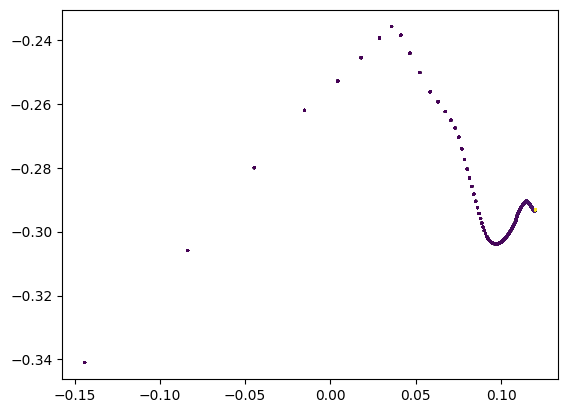

In [27]:
model_output, model_state = saved_model.test(task.get_trial_batch()[0])

for i in range(128):
    plt.scatter(model_output[i][:, 0], model_output[i][:, 1], s=1, c=np.arange(model_output.shape[1]))